In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os, sys
from matplotlib import cm
from matplotlib.patches import Circle,Wedge,Rectangle
%matplotlib inline

In [2]:
data=pd.read_excel(r"N:\Planning - New File Structure\Performance\RidershipAutomation.xlsx")
df=pd.DataFrame(data)

In [3]:
df.set_index(['Stat','Service','Route','Area'],inplace=True)

In [4]:
df.columns=pd.to_datetime(df.columns)

In [5]:
UPT_FR_18=df.loc[['UPT','FR'],datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)]
UPT_FR_17=df.loc[['UPT','FR'],datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)]

In [6]:
UPT_FR_17_Total=UPT_FR_17.sum(axis=0).sum()
UPT_FR_18_Total=UPT_FR_18.sum(axis=0).sum()

In [7]:
YearOverYearRidership=(UPT_FR_18_Total-UPT_FR_17_Total).round(-2)
YearOverYearRidershipPct=int(((UPT_FR_18_Total/UPT_FR_17_Total)-1)*100)
YearOverYearRidershipPct

10

In [8]:
ring_data=pd.DataFrame([UPT_FR_18_Total,UPT_FR_17_Total]).T
ring_data.columns=['2018','2017']

In [9]:
def degree_range(n): 
    start = np.linspace(-90,90,n+1, endpoint=True)[0:-1]
    end = np.linspace(-90,90,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

In [10]:
def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

In [11]:
def gauge(labels=['LOW','MEDIUM','HIGH','VERY HIGH','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False,arrow_size=1): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, (0.225*(arrow_size/2)) * np.cos(np.radians(-pos)), 0.225 * np.sin(np.radians(-pos)), \
                 width=0.04*(arrow_size/2), head_width=0.09*(arrow_size/2), head_length=0.1*(arrow_size/2), fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02*(arrow_size/2), facecolor='k'))
    #ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

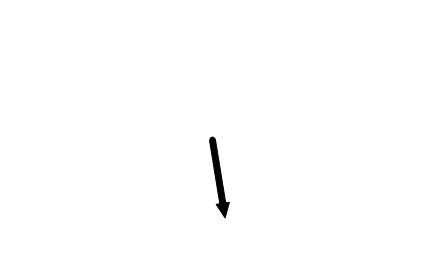

In [12]:
gauge(labels=['','','','',''],colors=['#ffffff','#ffffff','#ffffff','#ffffff','#ffffff'],arrow=int(YearOverYearRidershipPct/6),arrow_size=1) 

In [13]:
by_route18=df.loc[:,datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)].groupby('Route').sum()
by_route17=df.loc[:,datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)].groupby('Route').sum()

by_route18=by_route18.sum(axis=1)
by_route17=by_route17.sum(axis=1)

ring_data_routes=pd.DataFrame([by_route18,by_route17]).T
ring_data_routes.columns=['2018','2017']

In [14]:
ring_data_routes['PercentChange']=ring_data_routes['2018']/ring_data_routes['2017']
ring_data_routes['Change']=ring_data_routes['2018']-ring_data_routes['2017']
arrow_quints=pd.DataFrame(ring_data_routes.PercentChange.quantile([.2,.4,.6,.8]))

In [15]:
ring_data_routes['Arrow']=pd.qcut(ring_data_routes['PercentChange'],5,labels=[1,2,3,4,5])
ring_data_routes['Size']=pd.qcut(ring_data_routes['Change'],5,labels=[1,2,3,4,5])
ring_data_routes['Arrow']=ring_data_routes.Arrow.astype(float)
ring_data_routes['Size']=ring_data_routes.Size.astype(int)

In [16]:
ring_data_routes.head()

,2018,2017,PercentChange,Change,Arrow,Size
Route,,,,,,
1 Parkcenter,77969.0316,77955.0793,1.000179,13.9523,2.0,2
10 Hill Road - Maple Grove,50350.0757,54050.2547,0.931542,-3700.1790,1.0,1
10X,2343.2500,1953.2300,1.199680,390.0200,4.0,3
11 Garden City,15852.6713,19250.7767,0.823482,-3398.1054,1.0,1
12 Maple Grove,43127.0204,33612.7816,1.283054,9514.2388,4.0,4


In [17]:
#ring_data_routes=ring_data_routes.groupby(['Route'])

In [18]:
arrow=ring_data_routes.iloc[:,4]
size=ring_data_routes.iloc[:,5]
needs=pd.DataFrame([arrow,size]).T

In [19]:
needs.Arrow=needs.Arrow.map(int)
needs.Size=needs.Size.map(int)

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



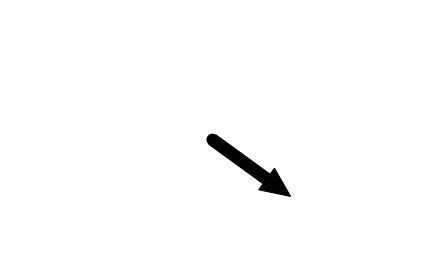

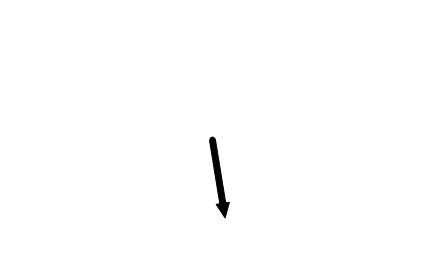

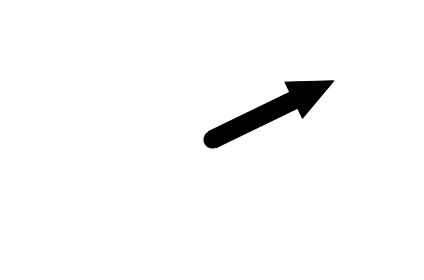

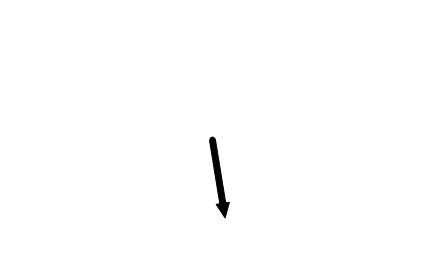

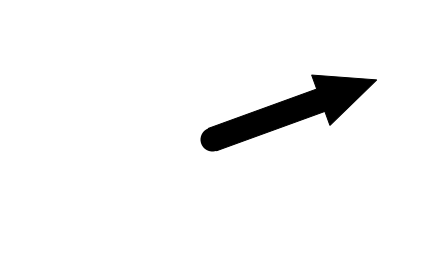

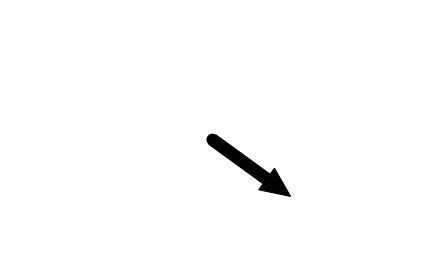

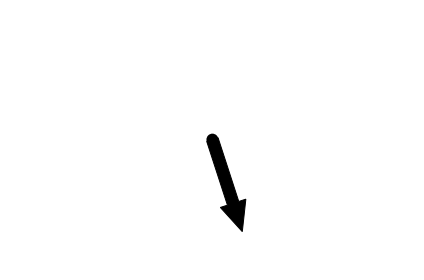

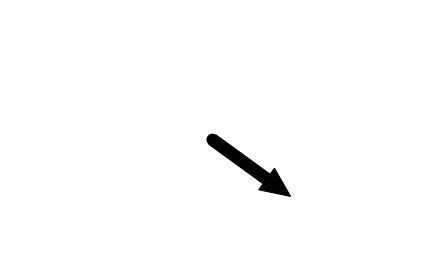

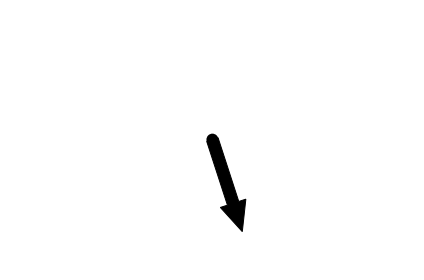

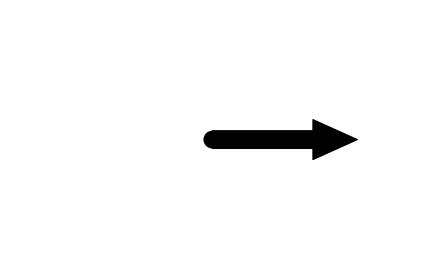

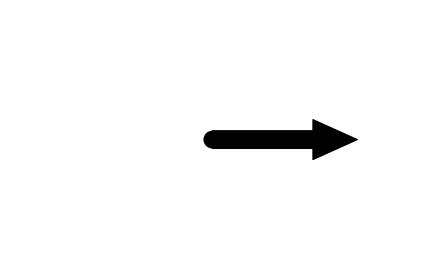

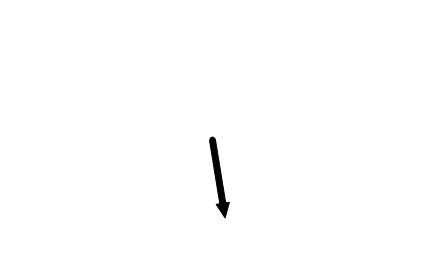

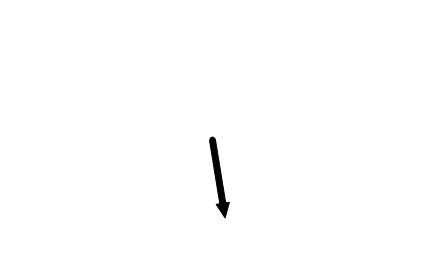

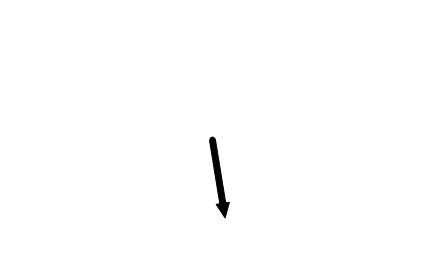

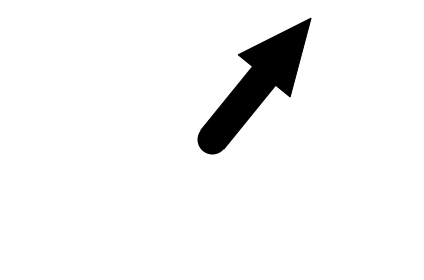

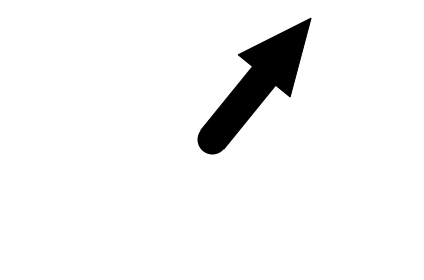

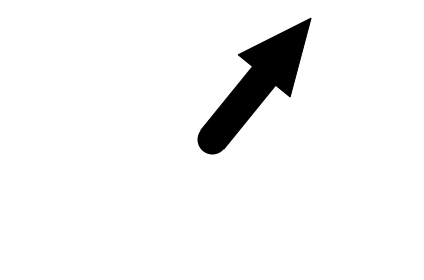

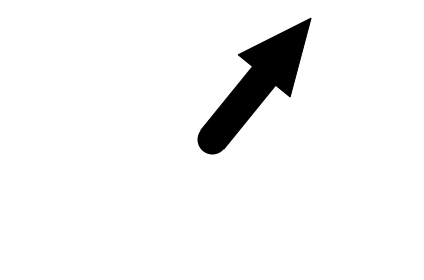

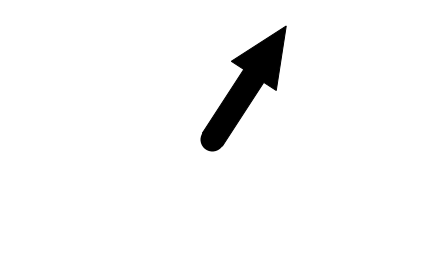

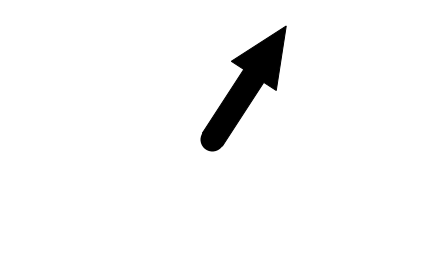

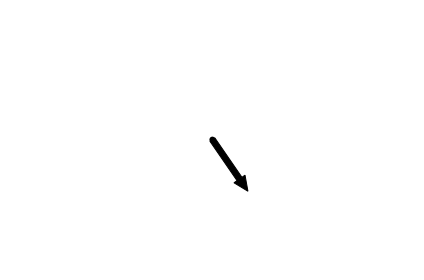

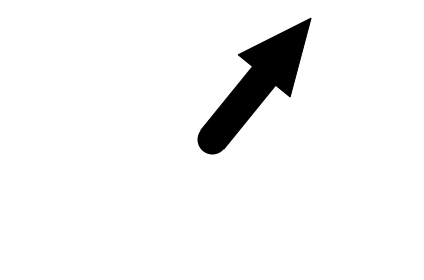

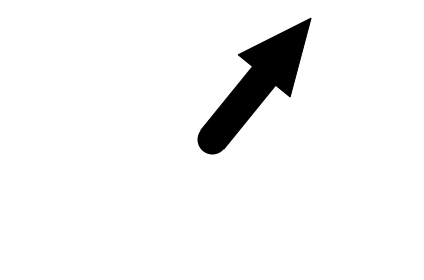

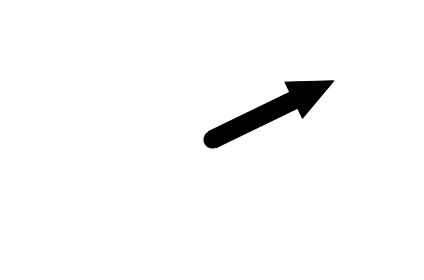

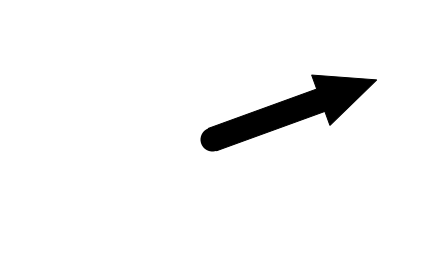

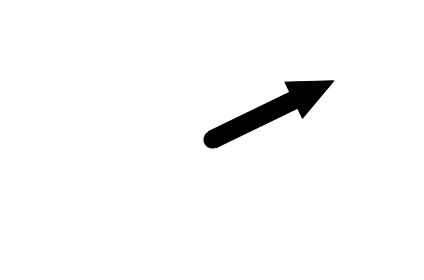

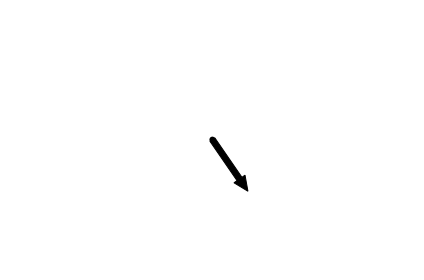

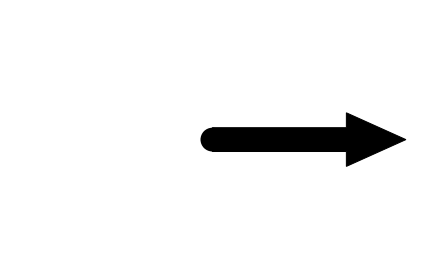

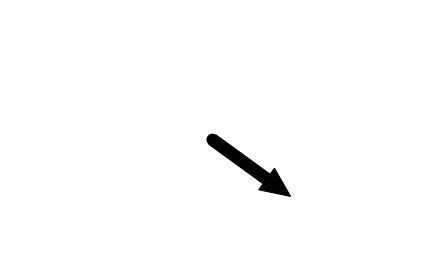

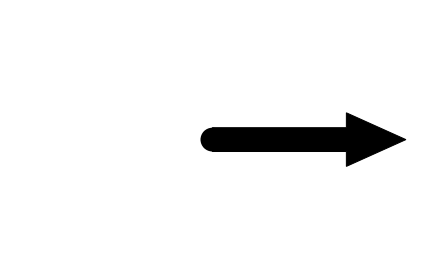

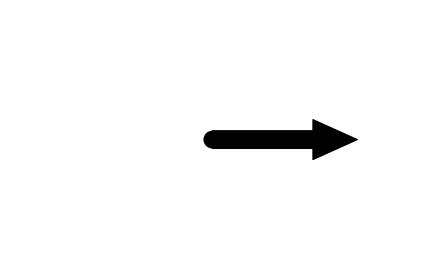

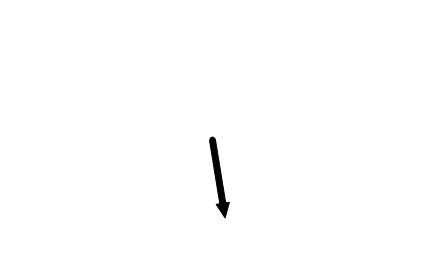

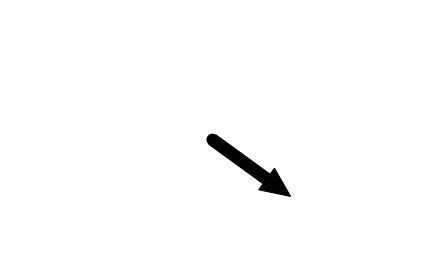

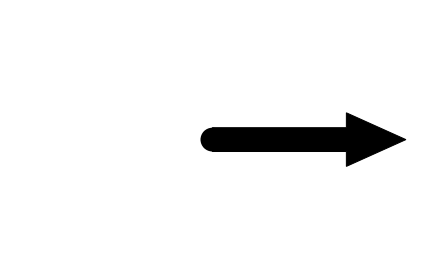

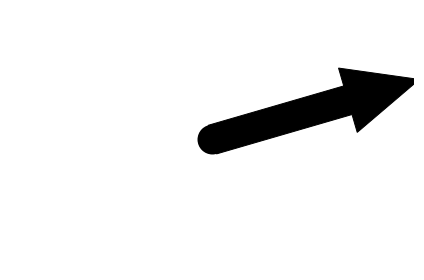

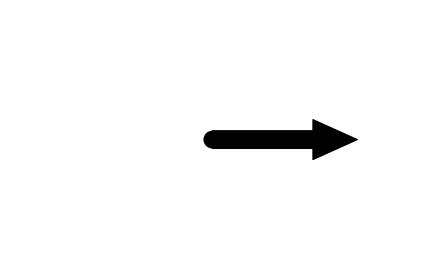

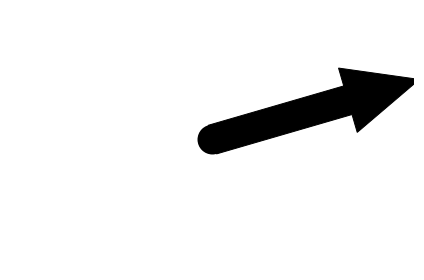

In [20]:
for index, row in needs.iterrows():
    gauge(labels=['','','','',''],colors=['#ffffff','#ffffff','#ffffff','#ffffff','#ffffff'],arrow=row['Arrow'],arrow_size=row['Size'])